In [1]:
# Import libraries
from openslide import OpenSlide
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage
from skimage import io, color, measure

Dimensions of full image (level 0): (59760, 28454)
Number of levels: 3
Dimensions of each level: [(59760, 28454), (14940, 7113), (3735, 1778)]
aperio


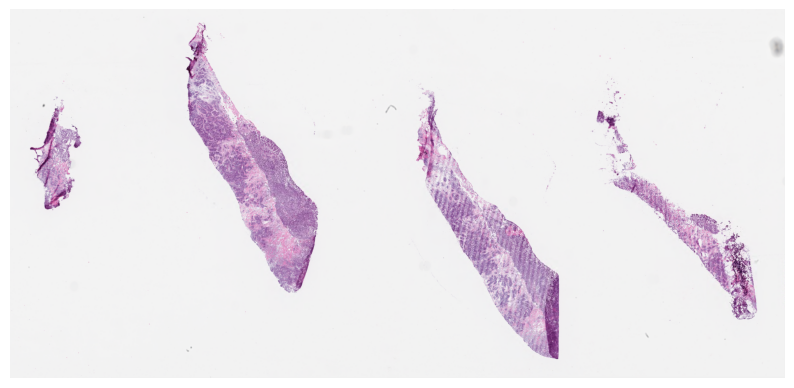

In [2]:
# Load an example SVS file
svs_path = "/Users/ashishsingh/Desktop/470650.svs" 
slide = OpenSlide(svs_path)

# Print some basic slide properties
print("Dimensions of full image (level 0):", slide.dimensions)
print("Number of levels:", slide.level_count)
print("Dimensions of each level:", [slide.level_dimensions[i] for i in range(slide.level_count)])
vendor = slide.properties.get("openslide.vendor") # Check vendor
print(vendor)

# Select the lowest resolution level (highest level number)
lowest_res_level = slide.level_count - 1

# Read the whole slide at the selected low resolution level
low_res_image = slide.read_region((0, 0), lowest_res_level, slide.level_dimensions[lowest_res_level])
low_res_image = low_res_image.convert("RGB")  # Convert to RGB for better visualization

# Display the low-resolution whole slide image
plt.figure(figsize=(10, 10))  # Set figure size to fit the image
plt.imshow(low_res_image)
plt.axis("off")  # Hide axes
plt.show()

In [3]:
# Display PNG thumbnail
tn = slide.get_thumbnail(size=(500, 500))
tn.show()

357000
(238, 500, 3)


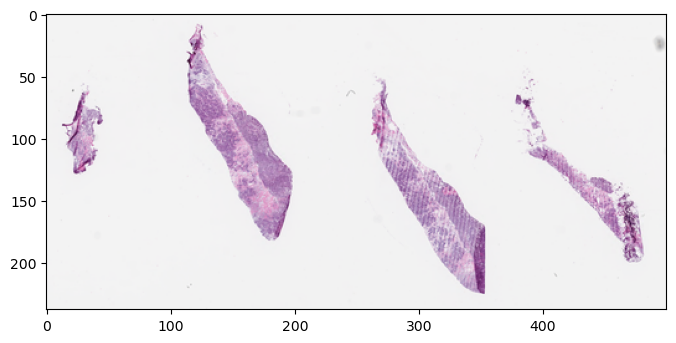

In [4]:
# Manipulate thumbnail
tn_np = np.array(tn)
print(tn_np.size)
print(tn_np.shape)

plt.figure(figsize=(8,8))
plt.imshow(tn_np)

((59760, 28454), (14940, 7113), (3735, 1778))
3
Each level is downsampled by (1.0, 4.000140587656404, 16.001687289088864)
2
<PIL.Image.Image image mode=RGBA size=3735x1778 at 0x10AE1EA20>


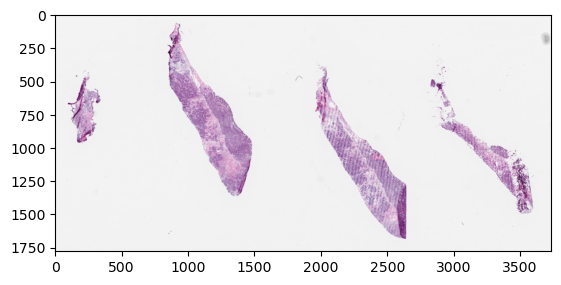

In [5]:
# Manipulate slide

dims = slide.level_dimensions
print(dims)
print(len(dims))

factors = slide.level_downsamples
print("Each level is downsampled by", factors)

SCALE_FACTOR=32
best_level = slide.get_best_level_for_downsample(SCALE_FACTOR)
print(best_level)

level3_dim = dims[2]
level3_img = slide.read_region((0,0),2, level3_dim)
print(level3_img)

level3_img_RGB = level3_img.convert('RGB')
level3_img_RGB.show()

level3_img_np = np.array(level3_img_RGB)
plt.imshow(level3_img_np)

In [6]:
# Manipulate tiles

from openslide.deepzoom import DeepZoomGenerator

tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)

print("Number of levels", tiles.level_count)
print("Dimensions in each level", tiles.level_dimensions)
print("Total number of tiles", tiles.tile_count)

Number of levels 17
Dimensions in each level ((1, 1), (2, 1), (4, 2), (8, 4), (15, 7), (30, 14), (59, 28), (117, 56), (234, 112), (467, 223), (934, 445), (1868, 890), (3735, 1779), (7470, 3557), (14940, 7114), (29880, 14227), (59760, 28454))
Total number of tiles 34988


In [7]:
# Checking an example tile features

level_num=11
print("The tiles shape at level", level_num, "is:", tiles.level_tiles[level_num])

print("This means there are", tiles.level_tiles[level_num][0]* tiles.level_tiles[level_num][1])

tile_dims = tiles.get_tile_dimensions(11,(0,0))
print(tile_dims)

The tiles shape at level 11 is: (8, 4)
This means there are 32
(256, 256)


In [8]:
# Exploring an example tile at level 16

tile_count_in_large_image = tiles.level_tiles[16]
print(tile_count_in_large_image)

tile_dims = tiles.get_tile_dimensions(16,(111,100))
print(tile_dims)

single_tile = tiles.get_tile(16, (20,40))
single_tile_RGB = single_tile.convert('RGB')
single_tile_RGB.show()

(234, 112)
(256, 256)


In [9]:
# Saving all tiles locally from an SVS file

cols, rows = tiles.level_tiles[16]

#import os
tile_dir = "/Users/ashishsingh/Desktop/tiles"
for row in range (rows):
    for col in range (cols):
        tile_name = os.path.join(tile_dir, f"{col}_{row}")
        print ("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16,(col,row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        plt.imsave(tile_name + ".png", temp_tile_np)

NameError: name 'os' is not defined

In [ ]:
img = cv2.imread("/Users/ashishsingh/Desktop/60_28.png", 0)
pixels_to_um = 0.5

plt.hist(img.flat, bins=100, range=(0,255))

ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
eroded = cv2.erode(thresh, kernel, iterations = 1)
dilated = cv2.dilate(eroded, kernel, iterations = 1)

#cv2.imshow("Threshold image", thresh)
#cv2.imshow("Eroded image", eroded)
cv2.imshow("Dilated image", dilated)
cv2.waitKey(0)

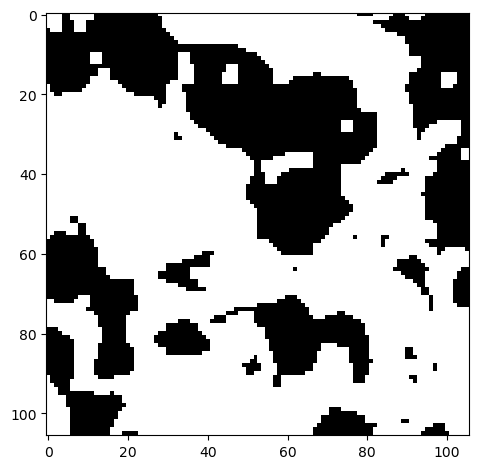

In [30]:
mask = dilated == 255
io.imshow(mask[150:280, 150:280])

In [ ]:
s = [[1,1,1], [1,1,1], [1,1,1]]
labeled_mask, num_labels = ndimage.label(mask, structure=s)

img2 = color.label2rgb(labeled_mask, bg_label=0)
cv2.imshow("Coloured labels", img2)
cv2.waitKey(0)

In [8]:
clusters = measure.regionprops(labeled_mask, img)

for prop in clusters:
    print('Label: {} Area {}'.format(prop.label, prop.area))

5408.742745817479
Label: 1 Area 37811.0
Label: 2 Area 452.0
Label: 3 Area 74.0
Label: 4 Area 34.0
Label: 5 Area 30.0
Label: 6 Area 31.0
Label: 7 Area 89.0
Label: 8 Area 14.0
Label: 9 Area 16.0
Label: 10 Area 12.0
Label: 11 Area 9.0
Label: 12 Area 9.0
Label: 13 Area 18.0
Label: 14 Area 9.0
Label: 15 Area 12.0
Label: 16 Area 9.0
Label: 17 Area 9.0
Label: 18 Area 9.0
Label: 19 Area 9.0
Label: 20 Area 24.0
Label: 21 Area 18.0
Label: 22 Area 19.0
Label: 23 Area 33.0
Label: 24 Area 9.0
Label: 25 Area 18.0
Label: 26 Area 15.0
Label: 27 Area 15.0
Label: 28 Area 25.0
Label: 29 Area 9.0
Label: 30 Area 6.0
Label: 31 Area 60.0
Label: 32 Area 74.0
Label: 33 Area 82.0
Label: 34 Area 55.0
Label: 35 Area 12.0
Label: 36 Area 66.0
Label: 37 Area 9.0
Label: 38 Area 44.0
Label: 39 Area 12.0
Label: 40 Area 362.0
Label: 41 Area 43.0
Label: 42 Area 9.0
Label: 43 Area 112.0
Label: 44 Area 31.0
Label: 45 Area 25.0
Label: 46 Area 43.0
Label: 47 Area 69.0


In [32]:
propList = ['Area',
            'equivalent_diameter',
            'orientation',
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']

In [33]:
import csv

with open('image_measurements.csv', 'w', newline='', encoding='utf-8') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(['Label'] + propList)  # Header row
    for cluster_props in clusters:
        row = [cluster_props['Label']]
        for prop in propList:
            if prop == 'Area':
                to_print = cluster_props[prop] * pixels_to_um**2
            elif prop == 'orientation':
                to_print = cluster_props[prop] * 57.2958
            elif prop.find('Intensity') < 0:
                to_print = cluster_props[prop] * pixels_to_um
            else:
                to_print = cluster_props[prop]
            row.append(to_print)
        writer.writerow(row)

In [13]:
# Import libraries
from openslide import OpenSlide
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage
from skimage import io, color, measure
import csv

In [9]:
# Watershed Segmentation for 1 image

img = cv2.imread("/Users/ashishsingh/Desktop/60_28.png", cv2.IMREAD_COLOR)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

pixels_to_um = 0.5

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)

ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

ret3, markers = cv2.connectedComponents(sure_fg)
markers += 10
markers[unknown==255] = 0

print(img.shape)  # Output: (height, width, channels)
if len(img.shape) == 2:  # Grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)




(256, 256, 3)


In [ ]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 255, 255]

img2 = color.label2rgb(markers, bg_label=0)

cv2.imshow("Overlay original image", img)
cv2.imshow("Coloured grains", img2)

plt.imshow(markers, cmap="jet")

cv2.imshow("Unknown", unknown)
cv2.waitKey(0)

In [7]:
from skimage.segmentation import clear_border
opening = clear_border (opening)

In [11]:
regions = measure.regionprops(markers, intensity_image=img)

propList = ['Area',
            'equivalent_diameter',
            'orientation',
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']

with open('image_measurements.csv', 'w', newline='', encoding='utf-8') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(['Label'] + propList)  # Header row
    for region_props in regions:
        row = [region_props['Label']]
        for prop in propList:
            if prop == 'Area':
                to_print = region_props[prop] * pixels_to_um**2
            elif prop == 'orientation':
                to_print = region_props[prop] * 57.2958
            elif prop.find('Intensity') < 0:
                to_print = region_props[prop] * pixels_to_um
            else:
                to_print = region_props[prop]
            row.append(to_print)
        writer.writerow(row)

In [16]:
# Watershed Segmentation for many images

import glob

pixels_to_um = 0.5

propList = ['Area',
            'equivalent_diameter',
            'orientation',
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']

path = "/Users/ashishsingh/Desktop/tiles/*.png*"
for file in glob.glob(path):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    from skimage.segmentation import clear_border
    opening = clear_border (opening)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)

    ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    ret3, markers = cv2.connectedComponents(sure_fg)
    markers += 10
    markers[unknown==255] = 0

    markers = cv2.watershed(img, markers)
    img[markers == -1] = [0, 255, 255]

    img2 = color.label2rgb(markers, bg_label=0)

    regions = measure.regionprops(markers, intensity_image=img)

    with open('image_measurements.csv', 'w', newline='', encoding='utf-8') as output_file:
        writer = csv.writer(output_file)
        writer.writerow(['Label'] + propList)  # Header row
        for region_props in regions:
            row = [region_props['Label']]
            for prop in propList:
                if prop == 'Area':
                    to_print = region_props[prop] * pixels_to_um**2
                elif prop == 'orientation':
                    to_print = region_props[prop] * 57.2958
                elif prop.find('Intensity') < 0:
                    to_print = region_props[prop] * pixels_to_um
                else:
                    to_print = region_props[prop]
                row.append(to_print)
            writer.writerow(row)

error: OpenCV(4.10.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
